In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
from PIL import Image
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

DIR = "/home/t-jachen/.kaggle/competitions/whale-categorization-playground"
SIZE = 200

from subprocess import check_output
print(check_output(["ls", DIR]).decode("utf8"))

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import random
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, GlobalMaxPooling2D
from keras.optimizers import RMSprop
from keras import backend as K

from tqdm import tqdm

num_classes = 10
epochs = 5

sample_submission.csv
test
test.zip
train
train.csv
train.zip



/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Importing the data

train_images = glob(DIR+"/train/*jpg")
test_images = glob(DIR+"/test/*jpg")
df = pd.read_csv(DIR+"/train.csv")

df1 = df.sample(frac=1)
#with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
   #print(df1)

In [3]:
df1["Image"] = df1["Image"].map( lambda x : DIR+"/train/"+x)
ImageToLabelDict = dict( zip( df1["Image"], df1["Id"]))

In [4]:
#image are imported with a resizing and a black and white conversion
def ImportImage(filename):
    img = Image.open(filename).convert("RGB").resize((SIZE,SIZE))
    x = np.array(img)
    return x
train_img = np.array([ImportImage(img) for img in train_images])

In [5]:
x_both = train_img
x_train = train_img[0:7000]
x_valid = train_img[7001:]
print(x_train.shape)
print(x_valid.shape)

(7000, 200, 200, 3)
(2849, 200, 200, 3)


In [6]:
# y_cat = list(map(ImageToLabelDict.get, train_images))
y_cat = [ImageToLabelDict[i] for i in train_images]

y_train = y_cat[0:7000]
y_valid = y_cat[7001:]
y_both = y_cat


In [7]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) +
                  (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))



def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    print(pred[0:100])
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


In [8]:
x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_both = x_both.astype('float32')
x_train /= 255
x_valid /= 255
x_both /= 255
input_shape = x_train.shape[1:]

In [9]:
def create_y_data(y_data):
#Create dictionary w/ {"Label" : [a, b, c]}, where [a, b, c] are indexes of that whale in y_train
    dictionary = {}
    for i in range(len(y_data)):
        index = y_data[i]
        if index == "new_whale" :
            temp=0
        elif index in dictionary:
            dictionary[index].append(i);
        else:
            dictionary[index] = [i];
        
    whaleArray = []
    for key, value in dictionary.items():
       whaleArray.append(value)
        
    #Creates dictionary with whale labels that have multiple images
    multWhales = {}
    for key, value in dictionary.items():
       if len(dictionary[key]) > 1:
           multWhales[key] = value
        
    multWhaleArray = []
    for key, value in multWhales.items():
           multWhaleArray.append(value)
    
    return multWhaleArray

In [10]:
mult_y_train = create_y_data(y_train)
mult_y_valid = create_y_data(y_valid)
mult_y_both = create_y_data(y_both)

In [12]:
'''
#Create dictionary w/ {"Label" : [a, b, c]}, where [a, b, c] are indexes of that whale in y_train
dictionary = {}
for i in range(len(y_both)):
    index = y_both[i]
    if index == "new_whale" :
        temp=0
    elif index in dictionary:
        dictionary[index].append(i);
    else:
        dictionary[index] = [i];
        
whaleArray = []
for key, value in dictionary.items():
    whaleArray.append(value)
        
#Creates dictionary with whale labels that have multiple images
multWhales = {}
for key, value in dictionary.items():
     if len(dictionary[key]) > 1:
            multWhales[key] = value
      
multWhaleArray = []
for key, value in multWhales.items():
    multWhaleArray.append(value)
    
whaleArraySorted = multWhaleArray
whaleArraySorted.append(whaleArray)
'''

'\n#Create dictionary w/ {"Label" : [a, b, c]}, where [a, b, c] are indexes of that whale in y_train\ndictionary = {}\nfor i in range(len(y_both)):\n    index = y_both[i]\n    if index == "new_whale" :\n        temp=0\n    elif index in dictionary:\n        dictionary[index].append(i);\n    else:\n        dictionary[index] = [i];\n        \nwhaleArray = []\nfor key, value in dictionary.items():\n    whaleArray.append(value)\n        \n#Creates dictionary with whale labels that have multiple images\nmultWhales = {}\nfor key, value in dictionary.items():\n     if len(dictionary[key]) > 1:\n            multWhales[key] = value\n      \nmultWhaleArray = []\nfor key, value in multWhales.items():\n    multWhaleArray.append(value)\n    \nwhaleArraySorted = multWhaleArray\nwhaleArraySorted.append(whaleArray)\n'

In [14]:
def create_pairs(x, multWhaleArray):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    numClasses = len(multWhaleArray)
    for i in (range(len(multWhaleArray))):
        for j in (range (len(multWhaleArray[i]))):
            #Anchor
            z1 = multWhaleArray[i][j]
        
            #Positive Pair
            if(len(multWhaleArray[i]) <= 2) :
                num = 1;
            else :
                inc = random.randrange(1, len(multWhaleArray[i]) )
                num = (i + inc) % len(multWhaleArray[i])
            z2 = multWhaleArray[i][num]
            pairs += [[x[z1], x[z2]]]
    
            #Negative Pair
            inc = random.randrange(1, num_classes)
            dn = (i + inc) % num_classes
            if(len(multWhaleArray[dn]) <= 2) :
                num = 1;
            else :
                num = random.randrange(1, len(multWhaleArray[dn])-1)
            z2 = multWhaleArray[dn][num]
            pairs += [[x[z1], x[z2]]]
        
            labels += [1, 0]
        
    return np.array(pairs), np.array(labels)

In [15]:
def create_pairs1(x, multWhaleArray):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    numClasses = len(multWhaleArray)
    for i in tqdm(range(len(multWhaleArray))):
            #Anchor
            z1 = multWhaleArray[i][0]
        
            #Positive Pair
            if(len(multWhaleArray[i]) <= 2) :
                num = 1;
            else :
                inc = random.randrange(1, len(multWhaleArray[i]))
                num = (i + inc) % len(multWhaleArray[i])
            z2 = multWhaleArray[i][num]
            pairs += [[x[z1], x[z2]]]
    
            #Negative Pair
            inc = random.randrange(1, num_classes)
            dn = (i + inc) % num_classes
            if(len(multWhaleArray[dn]) <= 2) :
                num = 1;
            else :
                num = random.randrange(1, len(multWhaleArray[dn])-1)
            z2 = multWhaleArray[dn][num]
            pairs += [[x[z1], x[z2]]]
        
            labels += [1, 0]
        
    return np.array(pairs), np.array(labels)

In [16]:
#Create the pairs
tr_pairs, tr_labels = create_pairs(x_train, mult_y_train)
v_pairs, v_labels = create_pairs(x_valid, mult_y_valid)
b_pairs, b_labels = create_pairs(x_both, mult_y_both)

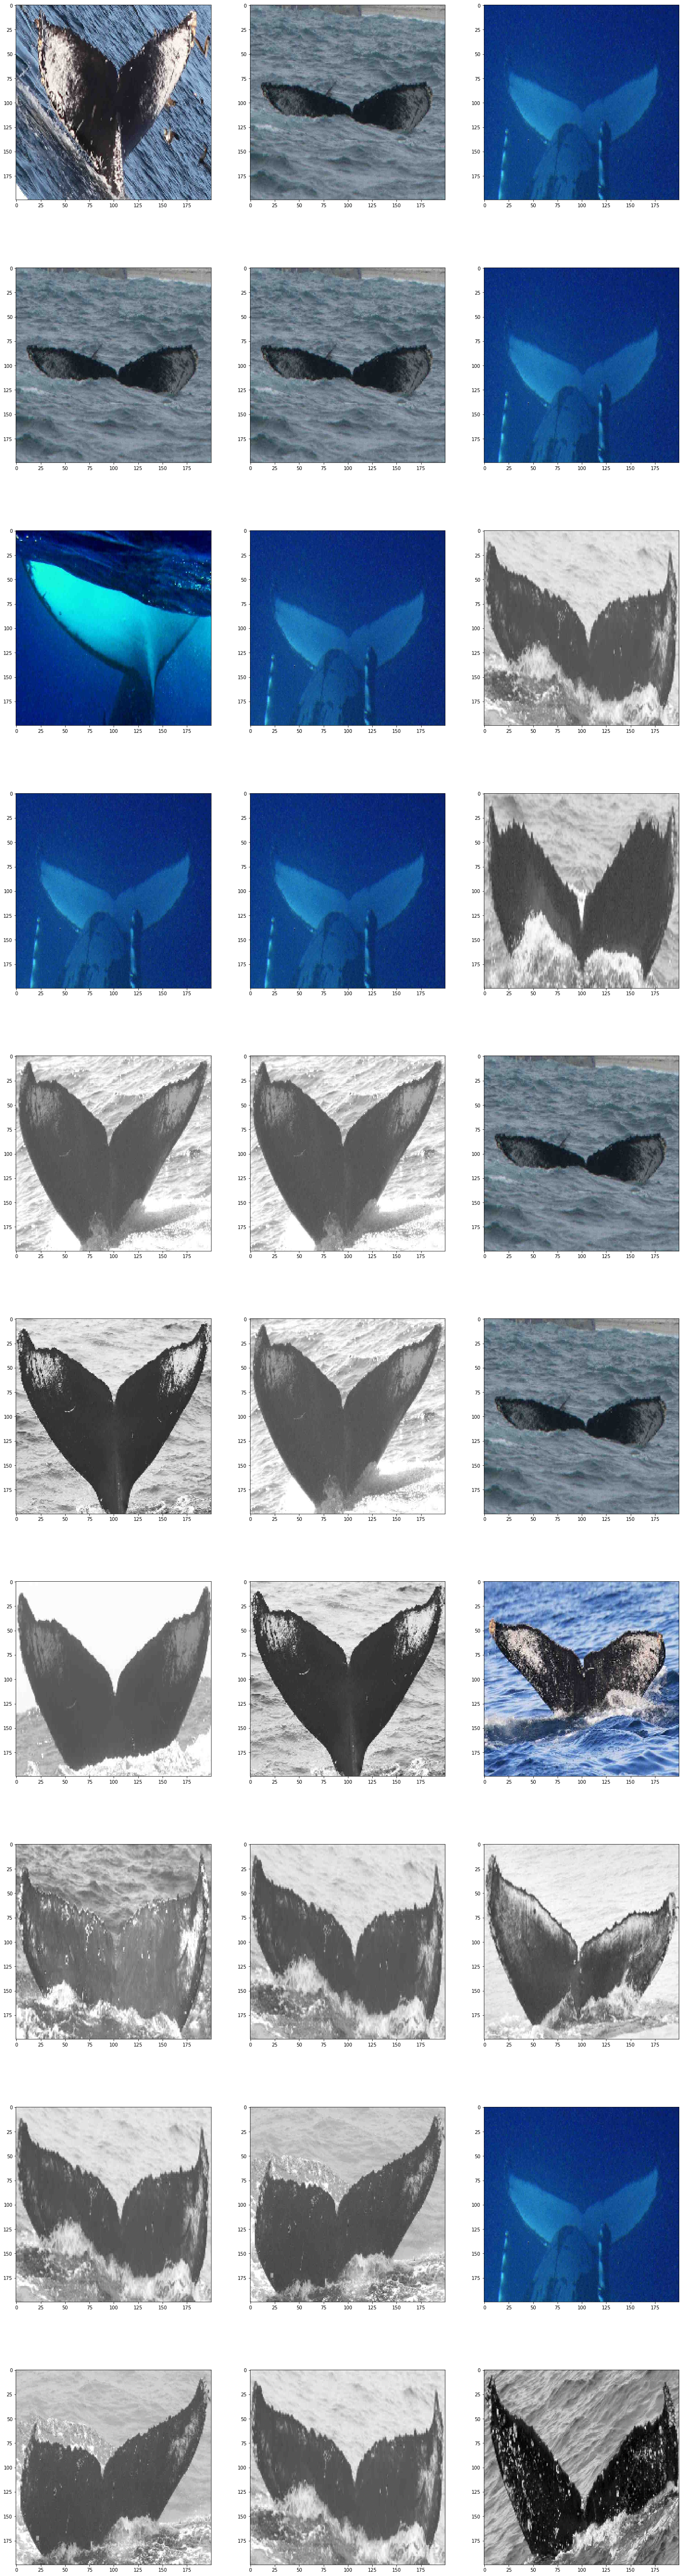

In [25]:
nTriplets = 10
plt.figure(figsize=(25,100))

# grid of 3x3 images
for i in range(0, nTriplets):
    plt.subplot(nTriplets, 3, 1 + i*3)
    plt.imshow(v_pairs[i*2][0])
    plt.subplot(nTriplets, 3, 2 + i*3)
    plt.imshow(v_pairs[i*2][1])
    plt.subplot(nTriplets, 3, 3 + i*3)
    plt.imshow(v_pairs[i*2+1][1])
plt.show()

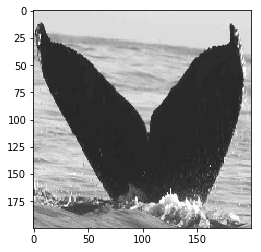

In [26]:
plt.imshow(tr_pairs[0][1])

In [27]:
def create_base_network1(input_shape):
    #base_model = keras.applications.densenet.DenseNet121(include_top=False, input_shape=(150, 150, 3))
    base_model = keras.applications.vgg19.VGG19(include_top=False, input_shape=(64, 64, 3), weights='imagenet')
    #base_model = keras.applications.resnet50.ResNet50(include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False
    base_model.layers[-2].trainable = True
    fc1 = base_model.layers[-3]
    fc2 = base_model.layers[-2]
    predictions = base_model.layers[-1]
    
    dropout1 = Dropout(0.25)
    dropout2 = Dropout(0.25)
    
    x = dropout1(fc1.output)
    x = fc2(x)
    x = dropout2(x)
    x = predictions(x)
    #x = base_model.output
    x = GlobalMaxPooling2D()(x)
    x = Dense(128, activation="softmax")(x)
    x = Dropout(0.25)(x)
    model = Model(base_model.input, x, name="cat_dog_model")
    
    
    
    model.summary()
    return model

In [18]:
# network definition
base_network = create_base_network1(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

In [19]:
# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

In [20]:
distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

In [24]:
# train
from keras.optimizers import SGD
from keras.callbacks import CSVLogger
from keras.callbacks import ModelCheckpoint
csv_logger = CSVLogger('/home/t-jachen/JupyterTest/whaleTails.log')
checkpointer = ModelCheckpoint(filepath='/home/t-jachen/JupyterTest/PTest.txt', verbose=1, save_best_only=False)
sgd = SGD(lr = 0.01, decay=1e-6, momentum=0.9, nesterov=True)
rms = RMSprop(lr=0.1)
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_labels,
          batch_size=32, #validation_split = 0.289,
          validation_data = ([v_pairs[:, 0], v_pairs[:, 1]], v_labels),
          epochs=30, initial_epoch = 0, shuffle = True)
'''
for ep in range(10):
    model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_labels,
          batch_size=16,
          epochs=10, callbacks=[checkpointer]) #initial_epoch = 0
'''

Hello, fit model
Doing validation on:
Train on 8596 samples, validate on 2322 samples
Epoch 1/30
8596/8596 [==============================] - 220s 26ms/step - loss: 0.6463 - accuracy: 0.4986 - val_loss: 0.4997 - val_accuracy: 0.5000
Epoch 2/30
8596/8596 [==============================] - 220s 26ms/step - loss: 0.6325 - accuracy: 0.5081 - val_loss: 0.4997 - val_accuracy: 0.5000
Epoch 3/30
8596/8596 [==============================] - 220s 26ms/step - loss: 0.6491 - accuracy: 0.4943 - val_loss: 0.4997 - val_accuracy: 0.5000
Epoch 4/30
8596/8596 [==============================] - 220s 26ms/step - loss: 0.6381 - accuracy: 0.5076 - val_loss: 0.4997 - val_accuracy: 0.5000
Epoch 5/30
8596/8596 [==============================] - 220s 26ms/step - loss: 0.6482 - accuracy: 0.4985 - val_loss: 0.4997 - val_accuracy: 0.5000
Epoch 6/30
7200/8596 [========================>.....] - ETA: 28s - loss: 0.6543 - accuracy: 0.4936

KeyboardInterrupt: 

In [ ]:
y_pred1 = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]], verbose = 1)
tr_acc = compute_accuracy(tr_labels, y_pred1)
print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print(y_pred1[0:100])


In [ ]:
y_pred = model.predict([v_pairs[:, 0], v_pairs[:, 1]], verbose = 1)
v_acc = compute_accuracy(v_labels, y_pred)
print('* Accuracy on training set: %0.2f%%' % (100 * v_acc))
print(y_pred)

In [ ]:
y_pred2 = model.predict([b_pairs[:, 0], b_pairs[:, 1]], verbose = 1)
v_acc = compute_accuracy(b_labels, y_pred2)
print('* Accuracy on training set: %0.2f%%' % (100 * v_acc))
print(y_pred2)

In [28]:
y_pred.shape
y_pred2 = y_pred[:, 0]
print(y_pred2)
y_pred2.shape

[0.16707799 0.16178189 0.00031623 ... 0.07015401 0.00031623 0.07242502]


(2322,)

In [29]:
print(v_labels)
v_labels.shape

[1 0 1 ... 0 1 0]


(2322,)

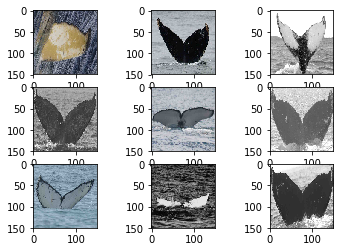

In [30]:
# grid of 3x3 images
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(Image.open(train_images[i]).convert("RGB").resize( (SIZE,SIZE)))
plt.show()

In [31]:
train_images

['/home/t-jachen/.kaggle/competitions/whale-categorization-playground/train/9f52074b.jpg',
 '/home/t-jachen/.kaggle/competitions/whale-categorization-playground/train/4042398c.jpg',
 '/home/t-jachen/.kaggle/competitions/whale-categorization-playground/train/4c4f06c4.jpg',
 '/home/t-jachen/.kaggle/competitions/whale-categorization-playground/train/d4789b2c.jpg',
 '/home/t-jachen/.kaggle/competitions/whale-categorization-playground/train/8d4fe30d.jpg',
 '/home/t-jachen/.kaggle/competitions/whale-categorization-playground/train/24451ede.jpg',
 '/home/t-jachen/.kaggle/competitions/whale-categorization-playground/train/8467d731.jpg',
 '/home/t-jachen/.kaggle/competitions/whale-categorization-playground/train/6445cc0d.jpg',
 '/home/t-jachen/.kaggle/competitions/whale-categorization-playground/train/089ab9b8.jpg',
 '/home/t-jachen/.kaggle/competitions/whale-categorization-playground/train/5fc16450.jpg',
 '/home/t-jachen/.kaggle/competitions/whale-categorization-playground/train/b7e02768.jpg',

In [32]:
'''
RANDOM CODE SNIPPETS BELOW:
'''

'\nRANDOM CODE SNIPPETS BELOW:\n'

In [33]:
print( "%d training images" %x.shape[0])

print( "Nbr of samples/class\tNbr of classes")
for index, val in df["Id"].value_counts().value_counts().sort_index().iteritems():
    print( "%d\t\t\t%d" %(index,val))

NameError: name 'x' is not defined

In [ ]:
def plotImages( images_arr, n_images=10):
    fig, axes = plt.subplots(n_images, n_images, figsize=(12,12))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        if img.ndim != 2:
            img = img.reshape( (SIZE,SIZE))
        ax.imshow( img, cmap="Greys_r")
        ax.set_xticks(())
        ax.set_yticks(())
    plt.tight_layout()
    
plotImages(x)
x.shape

In [ ]:
'''
class LabelOneHotEncoder():
    def __init__(self):
        self.ohe = OneHotEncoder()
        self.le = LabelEncoder()
    def fit_transform(self, x):
        features = self.le.fit_transform( x)
        return self.ohe.fit_transform( features.reshape(-1,1))
    def transform( self, x):
        return self.ohe.transform( self.la.transform( x.reshape(-1,1)))
    def inverse_tranform( self, x):
        return self.le.inverse_transform( self.ohe.inverse_tranform( x))
    def inverse_labels( self, x):
        return self.le.inverse_transform( x)

y = list(map(ImageToLabelDict.get, train_images))
lohe = LabelOneHotEncoder()
y_cat = lohe.fit_transform(y)
'''


'''
#use of an image generator for preprocessing and data augmentation
x = x.reshape( (-1,SIZE,SIZE,1))
input_shape = x[0].shape
x_train = x.astype("float32")
y_train = y_cat

image_gen = ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    rescale=1./255,
    rotation_range=15,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True)

#training the image preprocessing
image_gen.fit(x_train, augment=True)

#visualization of some images out of the preprocessing
#augmented_images, _ = next( image_gen.flow( x_train, y_train.toarray(), batch_size=4*4))
augmented_images = next( image_gen.flow( x_train, y_train, batch_size=4*4))
#plotImages( augmented_images)
'''


In [ ]:
'''
#constructing class weights
WeightFunction = lambda x : 1./x**0.75
ClassLabel2Index = lambda x : lohe.le.inverse_tranform( [[x]])
CountDict = dict( df["Id"].value_counts())
class_weight_dic = { lohe.le.transform( [image_name])[0] : WeightFunction(count) for image_name, count in CountDict.items()}
del CountDict
'''

In [ ]:
for i in range(10):
    img = Image.open(train_images[i]).convert("RGB").resize( (SIZE,SIZE))
    x = np.array(img)
    x.shape
    plt.imshow(x)

In [ ]:
img = Image.open(train_images[i]).convert("RGB").resize( (SIZE,SIZE))
type(img)

In [ ]:
def plotImages( images_arr, n_images=4):
    fig, axes = plt.subplots(n_images, n_images, figsize=(64,64))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        if img.ndim != 2:
            img = img.reshape( (SIZE,SIZE))
        ax.imshow( img, cmap="Greys_r")
        ax.set_xticks(())
        ax.set_yticks(())
    plt.tight_layout()
    
#plotting training images from training set after resizing and BW conversion
plotImages( x)

In [ ]:


'''
JULIA'S CODE:
base_model = keras.applications.densenet.DenseNet121(include_top=False)
x = base_model.output
x = GlobalMaxPooling2D()(x)
x = Dense(2, activation="softmax")(x)
model = Model(base_model.input, x, name="cat_dog_model")
'''

'''
SIAMESE EXAMPLE CODE:
input = Input(shape=input_shape)
x = Flatten()(input)
x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(128, activation='relu')(x)
print(Model(input,x).summary())
return Model(input, x)

'''

In [ ]:
def create_base_network2(input_shape):
    input = Input(shape=input_shape)
    x = Flatten()(input)
    y = Dense(128, activation='relu')
    y.trainable = False
    x = y(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    
    model = Model(input, x)
    #for layer in model.layers:
     #   layer.trainable = True
    print (model.layers)
    return model

In [ ]:
def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    base_model = keras.applications.densenet.DenseNet121(include_top=False)
    #base_model = keras.applications.vgg19.VGG19(include_top=False)
    x = base_model.output
    x = GlobalMaxPooling2D()(x)
    x = Dense(2, activation="relu")(x)
   
 #  model = Model(base_model.input, x, name="cat_dog_model")
    #x = Dense(128, activation='relu')(x)
   # x = Dropout(0.1)(x)
    #x = Dense(128, activation='relu')(x)
   # x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    print(Model(input, x).summary())
    return Model(input, x)